In [1]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils

importlib.reload(paths)
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
fhr = pd.read_pickle(f"{paths.CLEAN_CUT_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_CUT_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_CUT_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((538, 9600), (538, 9600), (538,))

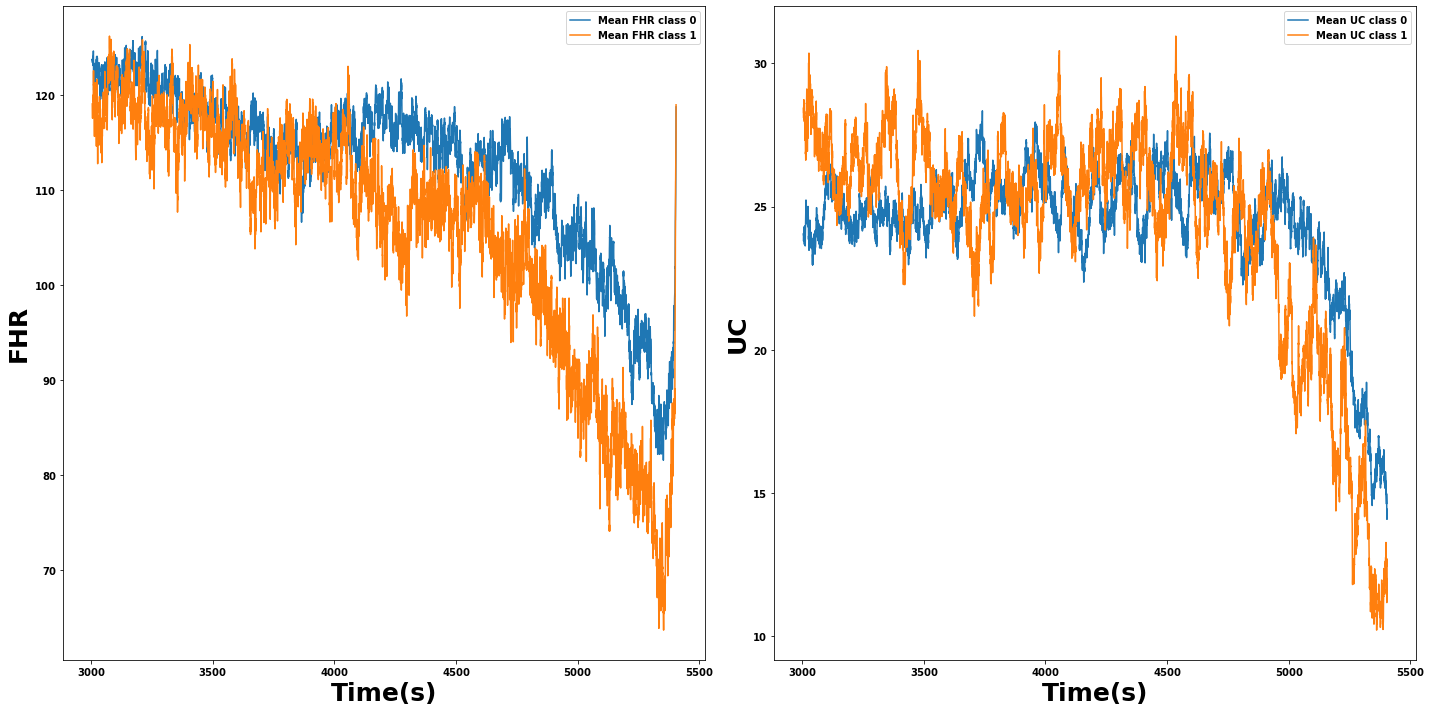

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].plot(fhr[y == 0].mean().index, fhr[y == 0].mean().values, label='Mean FHR class 0')
ax[0].plot(fhr[y == 1].mean().index, fhr[y == 1].mean().values, label='Mean FHR class 1')
ax[1].plot(uc[y == 0].mean().index, uc[y == 0].mean().values, label='Mean UC class 0')
ax[1].plot(uc[y == 1].mean().index, uc[y == 1].mean().values, label='Mean UC class 1')

ax[0].set_xlabel('Time(s)', fontsize=25)
ax[1].set_xlabel('Time(s)', fontsize=25)
ax[0].set_ylabel('FHR', fontsize=25)
ax[1].set_ylabel('UC', fontsize=25)
ax[0].legend()
ax[1].legend()
fig.tight_layout()

In [4]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr.copy().iterrows(), uc.copy().iterrows()), total=len(uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag) for lag in lags
    )
# 538/538 [02:24<00:00, 3.74it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
       ... 
9580    0.0
9581    0.0
9582    0.0
9583    0.0
9584    0.0
Length: 9026, dtype: float64

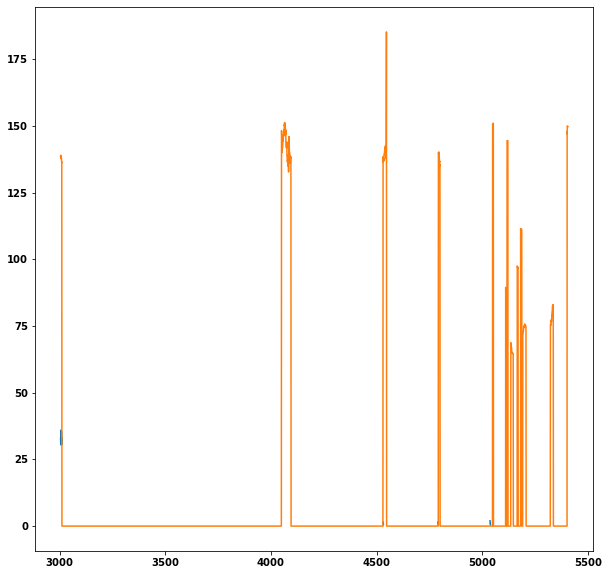

In [19]:
uc_signal = pd.Series(uc.loc[1058].values)
fhr_signal = pd.Series(fhr.loc[1058].values)

fig, ax = plt.subplots(1,1, figsize=(10, 10))

ax.plot(uc.columns, uc_signal.values)
ax.plot(fhr.columns, fhr_signal.values)
fhr_signal[(fhr_signal == 0)]

In [22]:
for idx, values in cc_data.items():
    nan_num = np.isnan(values).sum()
    if nan_num > 0:
        print(idx, nan_num)

1058 1868
1318 2399
1482 2399


In [ ]:
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

In [49]:
tt = np.array(lags)

cc_0 = cc_df.copy()[y == 0]
mean_0 = cc_0.mean().values
std_0 = cc_0.std().values
max_0 = cc_0.max().values
min_0 = cc_0.min().values

cc_1 = cc_df.copy()[y == 1]
mean_1 = cc_1.mean().values
std_1 = cc_1.std().values
max_1 = cc_1.max().values
min_1 = cc_1.min().values

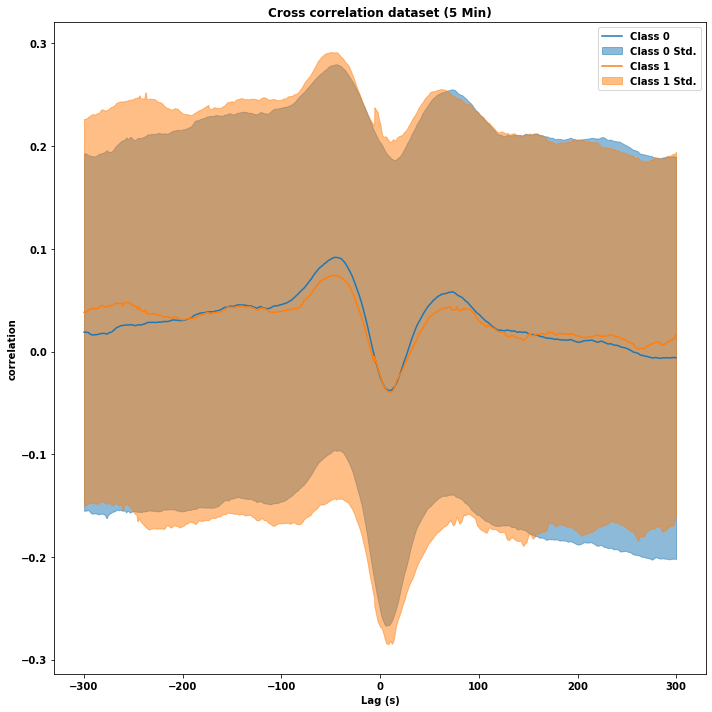

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(tt / 4, mean_0, label='Class 0', color=COLORS[0])
ax.fill_between(tt / 4, mean_0 - std_0, mean_0 + std_0, label='Class 0 Std.', alpha=0.5, color=COLORS[0])

ax.plot(tt / 4, mean_1, label='Class 1', color=COLORS[1])
ax.fill_between(tt / 4, mean_1 - std_1, mean_1 + std_1, label='Class 1 Std.', alpha=0.5, color=COLORS[1])

ax.legend(loc='best')
ax.set_title(f"Cross correlation dataset (5 Min)")
ax.set_ylabel(f"correlation")
ax.set_xlabel("Lag (s)")
fig.tight_layout()

plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot.pdf")

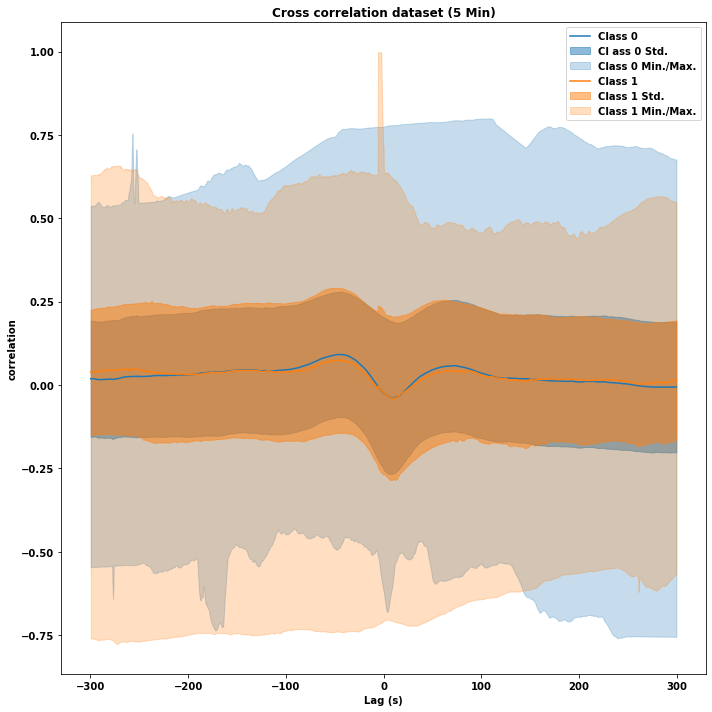

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(tt / 4, mean_0, label='Class 0', color=COLORS[0])
ax.fill_between(tt / 4, mean_0 - std_0, mean_0 + std_0, label='Cl ass 0 Std.', alpha=0.5, color=COLORS[0])
ax.fill_between(tt / 4, min_0, max_0, label='Class 0 Min./Max.', alpha=0.25, color=COLORS[0])

ax.plot(tt / 4, mean_1, label='Class 1', color=COLORS[1])
ax.fill_between(tt / 4, mean_1 - std_1, mean_1 + std_1, label='Class 1 Std.', alpha=0.5, color=COLORS[1])
ax.fill_between(tt / 4, min_1, max_1, label='Class 1 Min./Max.', alpha=0.25, color=COLORS[1])

ax.legend(loc='best')
ax.set_title(f"Cross correlation dataset (5 Min)")
ax.set_ylabel(f"correlation")
ax.set_xlabel("Lag (s)")
fig.tight_layout()

plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot_Mm.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot_Mm.pdf")

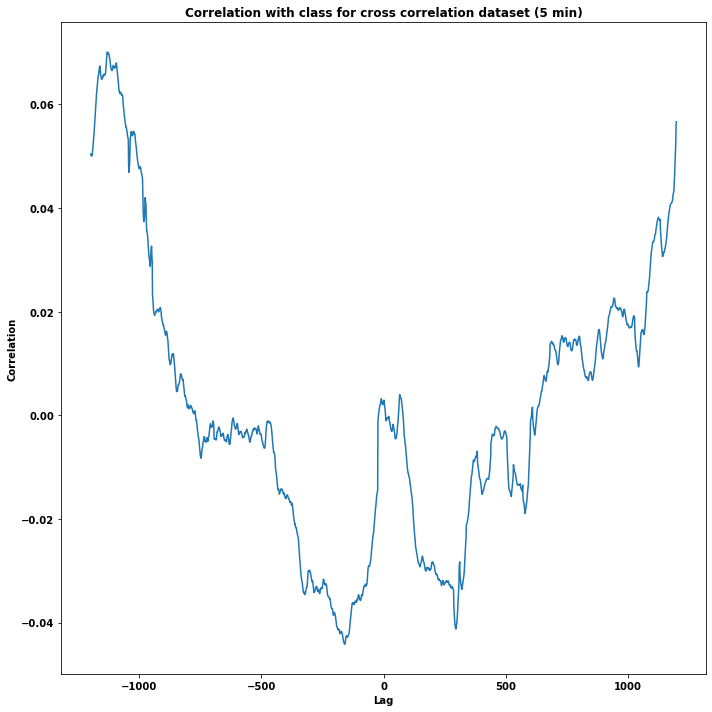

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

cc_df.corrwith(y).plot(ax=ax)

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag')
ax.set_title(f'Correlation with class for cross correlation dataset (5 min)')
fig.tight_layout()

plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_correlation.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_correlation.pdf")

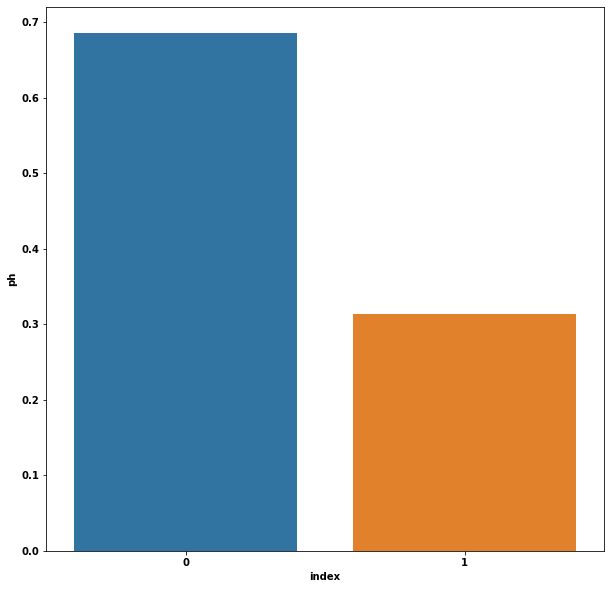

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x='index', y='ph', data=pd.DataFrame(y.value_counts(normalize=True)).reset_index())
plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_Distribution.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_Distribution.pdf")

In [61]:
cc_df['patologico'] = y

In [63]:
cc_df.to_csv(f"{paths.CC_DATA_PATH}/cc_dataset.csv")

In [65]:
X = cc_df.iloc[:, :-1]
X.to_pickle(f"{paths.CC_DATA_PATH}/X.pickle")
y.to_pickle(f"{paths.CC_DATA_PATH}/y.pickle")